In [40]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import average_precision_score, confusion_matrix
import sys
sys.path.append('../')
from src.utils.metrics.true_skill_statistic import vectorized_true_skill_statistic

%matplotlib inline

In [41]:
colors = {
    "yellow": "#EBB53D",
    "green": "#3B916D",
    "orange": "#DE8945",
    "blue": "#39909E",
    "red": "#EB4336",
    "black": "#231F20",
    "beige": "#EFEADF",
    "leafgreen": "#8CA530",
    "softmint": "#C3D9BF"
}

cm_to_inch = 1/2.54

onecolumn = 8.8 * cm_to_inch
twocolumn = 17.6 * cm_to_inch
onehalfcolumn = 13.2 * cm_to_inch

# Three row figure
# Set font to FiraCode NF (can remove if you don't have the font, not essential)
plt.rcParams["font.family"] = "FiraCode Nerd Font"

# Set all base black colors to my colors["black"]
plt.rcParams["text.color"] = colors["black"]
plt.rcParams["axes.labelcolor"] = colors["black"]
plt.rcParams["xtick.color"] = colors["black"]
plt.rcParams["ytick.color"] = colors["black"]
plt.rcParams["axes.edgecolor"] = colors["black"]


# Splits characterization table

In [3]:
# Connect to the features database
sdb_path = "../data/features.db"
sconn = sqlite3.connect(sdb_path)
scur = sconn.cursor()

# List all tables for reference
scur.execute("SELECT name FROM sqlite_master WHERE type='table';")

In [4]:
table = "T_24_L_24_S_0_2_B_0_OVERLAPS_1_MIN_FLARE_30_dataset"

In [5]:
# IMPORTANT IS_ACTIVE REFERS TO WHETHER A REGION PRODUCES ANY KIND OF FLARE, NOT ONLY >M. IS_CME_ACTIVE THE SAME, ANY KIND OF CME.
data = pd.read_sql(f"""
SELECT 
  split,
  COUNT(DISTINCT harpnum) AS n_unique_harpnum,
  COUNT(*) AS n_examples,
  SUM(CASE WHEN has_flare_above_threshold = 1 THEN 1 ELSE 0 END) AS n_flare_above_threshold_examples,
  SUM(CASE WHEN has_flare_below_threshold = 1 THEN 1 ELSE 0 END) AS n_flare_below_threshold_examples,
  SUM(CASE WHEN has_cme_flare_above_threshold = 1 THEN 1 ELSE 0 END) AS n_cme_flare_above_threshold_examples,
  SUM(CASE WHEN has_cme_flare_below_threshold = 1 THEN 1 ELSE 0 END) AS n_cme_flare_below_threshold_examples,
  COUNT(DISTINCT CASE WHEN has_flare_above_threshold = 1 THEN harpnum END) AS n_unique_harpnum_flare_above_threshold,
  COUNT(DISTINCT CASE WHEN has_flare_below_threshold = 1 THEN harpnum END) AS n_unique_harpnum_flare_below_threshold,
  COUNT(DISTINCT CASE WHEN has_cme_flare_above_threshold = 1 THEN harpnum END) AS n_unique_harpnum_cme_flare_above_threshold,
  COUNT(DISTINCT CASE WHEN has_cme_flare_below_threshold = 1 THEN harpnum END) AS n_unique_harpnum_cme_flare_below_threshold,
  COUNT(DISTINCT CASE WHEN is_flare_active = 1 THEN harpnum END) AS n_unique_harpnum_flare_active,
  COUNT(DISTINCT CASE WHEN is_flare_active = 0 THEN harpnum END) AS n_unique_harpnum_no_flare_active,
  COUNT(DISTINCT CASE WHEN is_cme_active = 1 THEN harpnum END) AS n_unique_harpnum_cme_active,
  COUNT(DISTINCT CASE WHEN is_cme_active = 0 THEN harpnum END) AS n_unique_harpnum_no_cme_active,
  COUNT(DISTINCT flare_above_threshold_id) AS n_unique_flare_above_threshold,
  COUNT(DISTINCT flare_below_threshold_id) AS n_unique_flare_below_threshold,
  COUNT(DISTINCT cme_flare_above_threshold_id) AS n_unique_cme_flare_above_threshold,
  COUNT(DISTINCT cme_flare_below_threshold_id) AS n_unique_cme_flare_below_threshold
FROM (
  SELECT 
    d.*,
    s.split,
    s.is_active as is_flare_active,
    s.is_cme_active as is_cme_active
  FROM {table} d
  INNER JOIN {table}_splits s
  ON d.harpnum = s.harpnum
) AS subquery
GROUP BY split;
""", sconn)

data["n_cme_examples"] = data["n_cme_flare_above_threshold_examples"] + data["n_cme_flare_below_threshold_examples"]
data["n_unique_cme"] = data["n_unique_cme_flare_above_threshold"] + data["n_unique_cme_flare_below_threshold"]
data["n_unique_harpnum_cme"] = data["n_unique_harpnum_cme_flare_above_threshold"] + data["n_unique_harpnum_cme_flare_below_threshold"]

data

,split,n_unique_harpnum,n_examples,n_flare_above_threshold_examples,n_flare_below_threshold_examples,n_cme_flare_above_threshold_examples,n_cme_flare_below_threshold_examples,n_unique_harpnum_flare_above_threshold,n_unique_harpnum_flare_below_threshold,n_unique_harpnum_cme_flare_above_threshold,...,n_unique_harpnum_no_flare_active,n_unique_harpnum_cme_active,n_unique_harpnum_no_cme_active,n_unique_flare_above_threshold,n_unique_flare_below_threshold,n_unique_cme_flare_above_threshold,n_unique_cme_flare_below_threshold,n_cme_examples,n_unique_cme,n_unique_harpnum_cme
0,0,302,170457,2696,24998,855,3692,14,69,8,...,233,34,268,46,638,9,44,4547,53,36
1,1,279,152986,2816,29469,799,3572,16,75,8,...,204,29,250,44,761,13,41,4371,54,31
2,2,279,145689,3824,24732,1286,3309,16,54,12,...,225,24,255,51,601,13,38,4595,51,32
3,3,269,152925,3435,24739,1446,3082,11,66,7,...,203,32,237,46,590,13,34,4528,47,33
4,4,309,167068,2805,26343,1131,3231,16,69,7,...,240,32,277,37,618,13,39,4362,52,37
5,5,290,152920,3241,23815,804,3843,21,57,5,...,233,24,266,45,543,12,41,4647,53,29
6,6,294,152657,3047,19584,1328,2922,13,50,5,...,244,18,276,47,495,21,41,4250,62,23
7,7,278,153449,2444,21857,739,3389,8,56,2,...,222,25,253,49,593,13,44,4128,57,27
8,8,301,160278,2900,22768,1090,2843,14,60,8,...,241,26,275,45,605,13,35,3933,48,30
9,9,280,149549,3001,21480,971,3675,13,50,5,...,230,20,260,46,577,13,46,4646,59,24


In [6]:
# Table with the total number of events per type (flare, cme, flare_cme)

n_events_data = pd.read_sql(f"""
SELECT 
  COUNT(DISTINCT flare_above_threshold_id) AS n_flare_above_threshold,
  COUNT(DISTINCT cme_flare_above_threshold_id) + COUNT(DISTINCT cme_flare_below_threshold_id) AS n_cme,
  COUNT(DISTINCT cme_flare_above_threshold_id) AS n_cme_flare_above_threshold,
  (SELECT COUNT(DISTINCT harpnum) FROM {table} WHERE has_flare_above_threshold = 1) AS n_flare_active,
  (SELECT COUNT(DISTINCT harpnum) FROM {table} WHERE has_cme_flare_above_threshold = 1 OR has_cme_flare_below_threshold = 1) AS n_cme_active,
  (SELECT COUNT(DISTINCT harpnum) FROM {table} WHERE has_cme_flare_above_threshold = 1) AS n_cme_flare_active,
  (SELECT COUNT(DISTINCT harpnum) FROM {table}) AS n_unique_harpnum_flare,
  (SELECT COUNT(DISTINCT harpnum) FROM {table}) AS n_unique_harpnum_cme,
  (SELECT COUNT(DISTINCT harpnum) FROM {table} WHERE has_flare_above_threshold = 1) AS n_unique_harpnum_cme_flare
  FROM {table}
  """, sconn
)

# Now let's format nicely into a table that has columns "Event", "N. Unique Events", "N. Event Active regions", "Total number of regions"

n_flare_above_threshold = n_events_data["n_flare_above_threshold"].values[0]
n_cme = n_events_data["n_cme"].values[0]
n_cme_flare_above_threshold = n_events_data["n_cme_flare_above_threshold"].values[0]
n_flare_active = n_events_data["n_flare_active"].values[0]
n_cme_active = n_events_data["n_cme_active"].values[0]
n_cme_flare_active = n_events_data["n_cme_flare_active"].values[0]
n_unique_harpnum_flare = n_events_data["n_unique_harpnum_flare"].values[0]
n_unique_harpnum_cme = n_events_data["n_unique_harpnum_cme"].values[0]
n_unique_harpnum_cme_flare = n_events_data["n_unique_harpnum_cme_flare"].values[0]

n_events_final_table = pd.DataFrame({
    "Event": ["Flare $>M$", "CME", "CME + Flare $>M$"],
    "N. Unique Events": [n_flare_above_threshold, n_cme, n_cme_flare_above_threshold],
    "N. Event Active regions": [n_flare_active, n_cme_active, n_cme_flare_active],
    "Total number of regions": [n_unique_harpnum_flare, n_unique_harpnum_cme, n_unique_harpnum_cme_flare]
})

# Save to latex
n_events_final_table.to_latex("./flare_cme_event_table.tex", index=False)

n_events_final_table

,Event,N. Unique Events,N. Event Active regions,Total number of regions
0,Flare $>M$,456,142,2881
1,CME,536,257,2881
2,CME + Flare $>M$,133,67,142


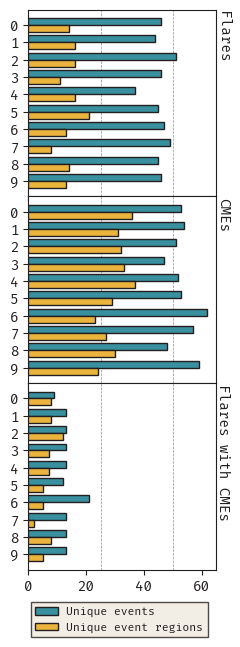

In [7]:
# Three row figure
# Set font to FiraCode NF
plt.rcParams["font.family"] = "FiraCode Nerd Font"

# Set all base black colors to my colors["black"]
plt.rcParams["text.color"] = colors["black"]
plt.rcParams["axes.labelcolor"] = colors["black"]
plt.rcParams["xtick.color"] = colors["black"]
plt.rcParams["ytick.color"] = colors["black"]
plt.rcParams["axes.edgecolor"] = colors["black"]

fig, axes = plt.subplots(3, 1, figsize=(0.7 * onecolumn, 2.1 * onecolumn), sharex=True)

# Remove vertical space between subplots
plt.subplots_adjust(hspace=0)

for ax in axes:
    # Set y ticks to 1 to 10 with step 1
    ax.set_yticks(np.arange(0, 10, 1))

column_names = (
("n_unique_flare_above_threshold", "n_unique_harpnum_flare_above_threshold"),
("n_unique_cme", "n_unique_harpnum_cme"),
("n_unique_cme_flare_above_threshold", "n_unique_harpnum_cme_flare_above_threshold")
)
fig_names = ("Flares", "CMEs", "Flares with CMEs")

for i in range(3):
    ax = axes[i]

    ax.set_title(fig_names[i], fontsize=10, rotation=-90,ha='left', va='top', y=0.95, x=1)

    # Invert y-axis
    ax.invert_yaxis()

    # Vertical grid at 0, 25 and 50
    ax.axvline(x=25, color=colors["black"], linewidth=0.5, linestyle="--", alpha=0.5, zorder=0, label="_nolegend_")
    ax.axvline(x=50, color=colors["black"], linewidth=0.5, linestyle="--", alpha=0.5, zorder=0, label="_nolegend_")

    # Horizontal bars with number of flares per split
    ax.barh(data["split"]-0.2, data[column_names[i][0]], color=colors["blue"], label="Unique Flares", height=0.4, linewidth=1, edgecolor=colors["black"], zorder=10)
    ax.barh(data["split"]+0.2, data[column_names[i][1]], color=colors["yellow"], label="Unique regions with flare", height=0.4, linewidth=1, edgecolor=colors["black"], zorder=10)


# Now a legend below the bottom plot with the colors and "N. unique events" and "N. unique regions with event"
# Create a legend
legend = fig.legend(
    loc="lower center",
    ncol=1,
    labels=["Unique events", "Unique event regions"],
    bbox_to_anchor=(0.5, 0.01),
    bbox_transform=fig.transFigure,
    fancybox=False,
    facecolor=colors["beige"],
    edgecolor=colors["black"],
    fontsize=8
)

plt.savefig("splits_fig.pdf", bbox_inches="tight")

In [8]:
summary_data = data[[
    "split",
    "n_unique_harpnum", 
    "n_examples", 
    "n_flare_above_threshold_examples",
    "n_cme_examples",
    "n_cme_flare_above_threshold_examples",
    ]].copy()

summary_data.rename(columns={
    "split": "Split",
    "n_unique_harpnum": "HARP regions",
    "n_examples": "Total examples",
    "n_flare_above_threshold_examples": "Flare examples",
    "n_cme_examples": "CME examples",
    "n_cme_flare_above_threshold_examples": "CME flare examples",
}, inplace=True)

summary_data.to_latex(index=False, buf="splits_table.tex")

# Model performance tables

In [42]:
preds_path = "../out/main_predictions.db"

conn = sqlite3.connect(preds_path)
cur = conn.cursor()

for table in ["flare_forecast", "cme_forecast", "flare_cme_assoc"]:
    cur.execute(f"CREATE INDEX IF NOT EXISTS {table}_harpnum_idx ON {table}_rotary_transformer_24_predictions (harpnum)")
    cur.execute(f"CREATE INDEX IF NOT EXISTS {table}_run_id_idx ON {table}_rotary_transformer_24_predictions (run_id)")

# Attach ../data/features.db

cur.execute("ATTACH DATABASE '../data/features.db' AS features")

# Delete temp view if exists
cur.execute("DROP TABLE IF EXISTS combined_forecasts")

cur.executescript("""
CREATE INDEX IF NOT EXISTS idx_flare_forecast ON flare_forecast_rotary_transformer_24_predictions(run_id, harpnum, start);
CREATE INDEX IF NOT EXISTS idx_cme_forecast ON cme_forecast_rotary_transformer_24_predictions(run_id, harpnum, start);
CREATE INDEX IF NOT EXISTS idx_flare_cme_assoc ON flare_cme_assoc_rotary_transformer_24_predictions(run_id, harpnum, start);

CREATE TEMP TABLE IF NOT EXISTS combined_forecasts AS
WITH unique_keys AS (
    SELECT run_id, harpnum, start, end FROM flare_forecast_rotary_transformer_24_predictions
    UNION
    SELECT run_id, harpnum, start, end FROM cme_forecast_rotary_transformer_24_predictions
    UNION
    SELECT run_id, harpnum, start, end FROM flare_cme_assoc_rotary_transformer_24_predictions
),
baselines AS (
                  SELECT 
                  harpnum, 
                  MAX(has_flare_above_threshold) AS baseline_flare,
                  MAX(MAX(has_cme_flare_above_threshold), MAX(has_cme_flare_below_threshold)) AS baseline_cme,
                  MAX(has_cme_flare_above_threshold) AS baseline_cme_flare
                  FROM features.T_24_L_24_S_0_2_B_0_OVERLAPS_1_MIN_FLARE_30_dataset
                  GROUP BY harpnum
),
combined_data AS (
    SELECT 
        uk.run_id, 
        uk.harpnum, 
        uk.start,
        uk.end,
        f.pred AS flare_pred, f.target AS flare_target,
        c.pred AS cme_pred, c.target AS cme_target,
        fc.pred AS flare_cme_pred, fc.target AS flare_cme_target,
        s.baseline_cme as base_cme_pred,
        s.baseline_cme_flare as base_flare_cme_pred,
        s.baseline_flare as base_flare_pred
    FROM unique_keys uk
    LEFT JOIN flare_forecast_rotary_transformer_24_predictions f ON uk.run_id = f.run_id AND uk.harpnum = f.harpnum AND uk.start = f.start
    LEFT JOIN cme_forecast_rotary_transformer_24_predictions c ON uk.run_id = c.run_id AND uk.harpnum = c.harpnum AND uk.start = c.start
    LEFT JOIN flare_cme_assoc_rotary_transformer_24_predictions fc ON uk.run_id = fc.run_id AND uk.harpnum = fc.harpnum AND uk.start = fc.start
    INNER JOIN baselines s ON uk.harpnum = s.harpnum
)
SELECT * FROM combined_data;
""")

In [43]:
def calculate_scores(predictions, base_predictions, true_labels, threshold, doprint=False):
    binary_predictions = (predictions > threshold).astype(int)
    base_binary_predictions = (base_predictions > threshold).astype(int)
    cm = confusion_matrix(true_labels, binary_predictions)
    bcm = confusion_matrix(true_labels, base_binary_predictions)
    TN, FP, FN, TP = cm.ravel()
    BTN, BFP, BFN, BTP = bcm.ravel()

    recall = TP / (TP + FN)
    b_recall = BTP / (BTP + BFN)
    precision = TP / (TP + FP)
    b_precision = BTP / (BTP + BFP)
    acc = (TP + TN) / (TP + TN + FP + FN)
    b_acc = (BTP + BTN) / (BTP + BTN + BFP + BFN)
    bacc = 1/2 * (TP / (TP + FN) + TN / (TN + FP))
    b_bacc = 1/2 * (BTP / (BTP + BFN) + BTN / (BTN + BFP))
    HSS = 2 * (TP * TN - FP * FN) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))
    b_HSS = 2 * (BTP * BTN - BFP * BFN) / ((BTP + BFN) * (BFN + BTN) + (BTP + BFP) * (BFP + BTN))
    TSS = recall - (FP / (FP + TN))
    b_TSS = b_recall - (BFP / (BFP + BTN))
    F1 = 2 * (precision * recall) / (precision + recall)
    b_F1 = 2 * (b_precision * b_recall) / (b_precision + b_recall)
    avg_pres_score = average_precision_score(true_labels, predictions)
    b_avg_pres_score = average_precision_score(true_labels, base_predictions)

    if doprint:
        print(f"Recall: {recall}")
        print(f"Precision: {precision}")
        print(f"Accuracy: {acc}")
        print(f"Balanced Accuracy: {bacc}")
        print(f"Heidke Skill Score: {HSS}")
        print(f"True Skill Statistic: {TSS}")
        print(f"Average Precision Score: {avg_pres_score}")

    return recall, precision, acc, bacc, HSS, TSS, avg_pres_score, b_recall, b_precision, b_acc, b_bacc, b_HSS, b_TSS, b_avg_pres_score, F1, b_F1, TN, FP, FN, TP


In [44]:

def get_independent_metrics(data=None, threshold=None, only_active=False, print_cm=True):
    if data is None:
        raise ValueError("Data must be provided.")

    metrics = pd.DataFrame(columns=["run_id", "type", "threshold", "recall", "precision", "accuracy", "balanced_accuracy", "heidke_skill_score", "true_skill_statistic", "average_precision_score", "b_recall", "b_precision", "b_accuracy", "b_balanced_accuracy", "b_heidke_skill_score", "b_true_skill_statistic", "b_average_precision_score", "F1", "b_F1"])

    cms = {}
    for forecast_type in ["flare", "cme", "flare_cme"]:
        cms[forecast_type] = {
            "TN": [], 
            "FP":  [],
            "FN": [], 
            "TP": []
        }


    for run_id in tqdm(data["run_id"].unique()):
        for forecast_type in ["flare", "cme", "flare_cme"]:
            run_data = data[data["run_id"] == run_id]

            if only_active:
                run_data = run_data[run_data[f"base_{forecast_type}_pred"] == 1]

            predictions, true_labels, base_predictions = run_data[[f"{forecast_type}_pred", f"{forecast_type}_target", f"base_{forecast_type}_pred"]].dropna().values.T

            assert len(predictions) == len(true_labels), "Predictions and true labels must have the same length."

            # If threshold is none, calculate TSS for several thresholds and select the one that maximizes TSS
            if threshold is None:
                thresholds = np.arange(0, 1.01, 0.01)
                tss_values = vectorized_true_skill_statistic(true_labels, predictions, thresholds)
                # So as to not overwrite threshold
                use_threshold = thresholds[np.argmax(tss_values)]
            else:
                use_threshold = threshold[forecast_type]

            recall, precision, acc, bacc, HSS, TSS, avg_pres_score, b_recall, b_precision, b_acc, b_bacc, b_HSS, b_TSS, b_avg_pres_score, F1, b_F1, TN, FP, FN, TP = calculate_scores(predictions, base_predictions, true_labels, use_threshold)

            cms[forecast_type]["TN"].append(TN)
            cms[forecast_type]["FP"].append(FP)
            cms[forecast_type]["FN"].append(FN)
            cms[forecast_type]["TP"].append(TP)

            metrics = pd.concat([metrics, pd.DataFrame({"run_id": run_id, "type": forecast_type, "threshold": use_threshold, "recall": recall, "precision": precision, "accuracy": acc, "balanced_accuracy": bacc, "heidke_skill_score": HSS, "true_skill_statistic": TSS, "average_precision_score": avg_pres_score, "b_recall": b_recall, "b_precision": b_precision, "b_accuracy": b_acc, "b_balanced_accuracy": b_bacc, "b_heidke_skill_score": b_HSS, "b_true_skill_statistic": b_TSS, "b_average_precision_score": b_avg_pres_score, "F1": F1, "b_F1": b_F1}, index=[0])])

    if print_cm:
        for forecast_type in ["flare", "cme", "flare_cme"]:
            print("\n")
            print(forecast_type)
            TN = cms[forecast_type]["TN"]
            FP = cms[forecast_type]["FP"]
            FN = cms[forecast_type]["FN"]
            TP = cms[forecast_type]["TP"]
            print("TN", np.mean(TN), np.std(TN))
            print("FP", np.mean(FP), np.std(FP))
            print("FN", np.mean(FN), np.std(FN))
            print("TP", np.mean(TP), np.std(TP))

    return metrics

def get_combined_metrics(data=None, threshold=None, combine_cme_alone=False, print_cm = True):
    if data is None:
        data = pd.read_sql("""
        SELECT * FROM combined_forecasts
                        """, conn)

    metrics = pd.DataFrame(columns=["run_id", "type", "threshold", "recall", "precision", "accuracy", "balanced_accuracy", "heidke_skill_score", "true_skill_statistic", "average_precision_score", "b_recall", "b_precision", "b_accuracy", "b_balanced_accuracy", "b_heidke_skill_score", "b_true_skill_statistic", "b_average_precision_score", "F1", "b_F1"])

    cms = {}
    for forecast_type in ["flare", "cme", "flare_cme"]:
        cms[forecast_type] = {
            "TN": [], 
            "FP":  [],
            "FN": [], 
            "TP": []
        }

    for run_id in tqdm(data["run_id"].unique()):
        for forecast_type in ["cme", "flare_cme"]:
            use_threshold = threshold[forecast_type]
            run_data = data[data["run_id"] == run_id]
            flare_predictions, flare_true_labels, flare_base_predictions = run_data[run_data["flare_target"] == 1][[f"{forecast_type}_pred", f"{forecast_type}_target", f"base_{forecast_type}_pred"]].dropna().values.T
            flare_binary_preds = (flare_predictions > threshold["flare"]).astype(int)
            if forecast_type == "cme":
                # Only take predictions when there's a flare in the next 24 hours. For comparison with the flare-CME association model
                predictions, true_labels, base_predictions = run_data[run_data["flare_target"] == 1][[f"{forecast_type}_pred", f"{forecast_type}_target", f"base_{forecast_type}_pred"]].dropna().values.T
                print(f"Run ID: {run_id}, Forecast Type: {forecast_type}, Number of predictions: {len(predictions)}")
            elif forecast_type == "flare_cme":

                predictions, true_labels, base_predictions = run_data[run_data["flare_target"] == 1][[f"{forecast_type}_pred", f"{forecast_type}_target", f"base_{forecast_type}_pred"]].dropna().values.T

                # Now multiply predictions by the flare predictions. So, if didn't predict a flare, can't predict a CME. (0 * anything = 0)
                predictions = predictions * flare_binary_preds
                print(f"Run ID: {run_id}, Forecast Type: {forecast_type}, Number of predictions: {len(predictions)}")
            else:
                raise ValueError("Invalid forecast type.")

            assert len(predictions) == len(true_labels), "Predictions and true labels must have the same length."

            recall, precision, acc, bacc, HSS, TSS, avg_pres_score, b_recall, b_precision, b_acc, b_bacc, b_HSS, b_TSS, b_avg_pres_score, F1, b_F1, TN, FP, FN, TP = calculate_scores(predictions, base_predictions, true_labels, use_threshold)

            cms[forecast_type]["TN"].append(TN)
            cms[forecast_type]["FP"].append(FP)
            cms[forecast_type]["FN"].append(FN)
            cms[forecast_type]["TP"].append(TP)

            metrics = pd.concat([metrics, pd.DataFrame({"run_id": run_id, "type": forecast_type, "threshold": use_threshold, "recall": recall, "precision": precision, "accuracy": acc, "balanced_accuracy": bacc, "heidke_skill_score": HSS, "true_skill_statistic": TSS, "average_precision_score": avg_pres_score, "b_recall": b_recall, "b_precision": b_precision, "b_accuracy": b_acc, "b_balanced_accuracy": b_bacc, "b_heidke_skill_score": b_HSS, "b_true_skill_statistic": b_TSS, "b_average_precision_score": b_avg_pres_score, "F1": F1, "b_F1": b_F1}, index=[0])])

    if print_cm:
        for forecast_type in ["flare", "cme", "flare_cme"]:
            print("\n")
            print(forecast_type)
            TN = cms[forecast_type]["TN"]
            FP = cms[forecast_type]["FP"]
            FN = cms[forecast_type]["FN"]
            TP = cms[forecast_type]["TP"]
            print("TN", np.mean(TN), np.std(TN))
            print("FP", np.mean(FP), np.std(FP))
            print("FN", np.mean(FN), np.std(FN))
            print("TP", np.mean(TP), np.std(TP))

    return metrics

In [45]:
data = pd.read_sql("""
SELECT * FROM combined_forecasts
                    """, conn)

### First step is to get the threshold for each model

In [47]:
metrics = get_independent_metrics(data)

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_25535/1949432266.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics = pd.concat([metrics, pd.DataFrame({"run_id": run_id, "type": forecast_type, "threshold": use_threshold, "recall": recall, "precision": precision, "accuracy": acc, "balanced_accuracy": bacc, "heidke_skill_score": HSS, "true_skill_statistic": TSS, "average_precision_score": avg_pres_score, "b_recall": b_recall, "b_precision": b_precision, "b_accuracy": b_acc, "b_balanced_accuracy": b_bacc, "b_heidke_skill_score": b_HSS, "b_true_skill_statistic": b_TSS, "b_average_precision_score": b_avg_pres_score, "F1": F1, "b_F1": b_F1}, index=[0])])
100%|██████████| 10/10 [00:09<00:00,  1.10it/s]



flare
TN 271836.3 8915.330987125491
FP 33717.5 8551.660391409378
FN 318.3 111.28526407391053
TP 5723.5 536.823108668023


cme
TN 243532.0 9308.762484884874
FP 59600.8 8649.076144883915
FN 1062.5 319.56947601421507
TP 7053.9 367.57786930118635


flare_cme
TN 2442.5 626.2001676780357
FP 1509.5 704.6816657186421
FN 686.1 253.9320578422504
TP 1403.7 494.22081097420414


In [48]:

thresholds = metrics.groupby("type").agg(["mean", "std", "median", "min", "max"])["threshold"]["mean"].to_dict()
thresholds

{'cme': 0.307, 'flare': 0.246, 'flare_cme': 0.45999999999999996}

In [19]:
thresholded_metrics = get_independent_metrics(data, threshold=thresholds)
grouped_thresholded_metrics = thresholded_metrics.groupby("type").agg(["mean", "std"])

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_8159/1949432266.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics = pd.concat([metrics, pd.DataFrame({"run_id": run_id, "type": forecast_type, "threshold": use_threshold, "recall": recall, "precision": precision, "accuracy": acc, "balanced_accuracy": bacc, "heidke_skill_score": HSS, "true_skill_statistic": TSS, "average_precision_score": avg_pres_score, "b_recall": b_recall, "b_precision": b_precision, "b_accuracy": b_acc, "b_balanced_accuracy": b_bacc, "b_heidke_skill_score": b_HSS, "b_true_skill_statistic": b_TSS, "b_average_precision_score": b_avg_pres_score, "F1": F1, "b_F1": b_F1}, index=[0])])
100%|██████████| 10/10 [00:06<00:00,  1.59it/s]



flare
TN 273163.4 10205.364777409968
FP 32390.4 3128.820710747102
FN 479.0 316.63101553701273
TP 5562.8 633.4588858008071


cme
TN 244608.8 11798.159210656551
FP 58524.0 6381.050023311211
FN 1138.1 414.1626371366688
TP 6978.3 559.0102056313463


flare_cme
TN 2286.4 878.5110357872575
FP 1665.6 634.8226839047262
FN 822.5 395.6622928710796
TP 1267.3 487.6332740902737


In [20]:
# Now format for latex, we want only some columns and we wan mean (std)

latex_metrics = {
    "threshold": "Threshold",
    "true_skill_statistic": "TSS",
    "heidke_skill_score": "HSS",
    "average_precision_score": "AP",
    "F1": "F1",
                 }

# MUST HAVE FORMATTING THAT IS A STRING BEING FOR EACH LATEX METRIC MEAN (STD)

latex_thresholded_metrics = grouped_thresholded_metrics[[metric for metric in latex_metrics.keys()]].copy()

# Create new formatted column
for key, value in latex_metrics.items():
    for forecast_type in ["flare", "cme", "flare_cme"]:
        f_data = latex_thresholded_metrics.loc[forecast_type, key]
        if key == "threshold":
            latex_thresholded_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f}"
            continue
        latex_thresholded_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f} ({float(f_data['std']):.2f})"

# Drop old columns
latex_thresholded_metrics.drop(list(latex_metrics.keys()), axis=1, inplace=True)
latex_thresholded_metrics

# Convert to normal dataframe, type is another column

latex_thresholded_metrics.reset_index(inplace=True)

# Rename Forecast Type as follows
forcast_types = {
    "flare": "Flare",
    "cme": "CME",
    "flare_cme": "Flare-CME"
}

# Rename type to Forecast Type
latex_thresholded_metrics.rename(columns={"type": "Forecast Type"}, inplace=True)
# Rename the rows and order as in forecast_types
latex_thresholded_metrics["Forecast Type"] = latex_thresholded_metrics["Forecast Type"].map(forcast_types)

# Reorder the rows
latex_thresholded_metrics = latex_thresholded_metrics.reindex([1, 0, 2]).reset_index(drop=True)


latex_thresholded_metrics.to_latex(index=False, buf="thresholded_metrics.tex")
latex_thresholded_metrics

/tmp/ipykernel_8159/3620976278.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.25' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  latex_thresholded_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f}"
/tmp/ipykernel_8159/3620976278.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.81 (0.05)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  latex_thresholded_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f} ({float(f_data['std']):.2f})"
/tmp/ipykernel_8159/3620976278.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.23 (0.02)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  latex_thresholded_

,Forecast Type,Threshold,TSS,HSS,AP
,,,,,
0,Flare,0.25,0.81 (0.05),0.23 (0.02),0.45 (0.07)
1,CME,0.31,0.67 (0.05),0.15 (0.02),0.23 (0.06)
2,Flare-CME,0.46,0.17 (0.08),0.16 (0.08),0.47 (0.07)


In [21]:
# Now same table but with the baseline metrics

latex_metrics = {
    "b_true_skill_statistic": "TSS",
    "b_heidke_skill_score": "HSS",
    "b_average_precision_score": "AP",
                 }

# MUST HAVE FORMATTING THAT IS A STRING BEING FOR EACH LATEX METRIC MEAN (STD)

latex_thresholded_metrics = grouped_thresholded_metrics[[metric for metric in latex_metrics.keys()]].copy()

# Create new formatted column
for key, value in latex_metrics.items():
    for forecast_type in ["flare", "cme", "flare_cme"]:
        f_data = latex_thresholded_metrics.loc[forecast_type, key]
        if key == "threshold":
            latex_thresholded_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f}"
            continue
        latex_thresholded_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f} ({float(f_data['std']):.2f})"

# Drop old columns
latex_thresholded_metrics.drop(list(latex_metrics.keys()), axis=1, inplace=True)
latex_thresholded_metrics

# Convert to normal dataframe, type is another column

latex_thresholded_metrics.reset_index(inplace=True)

# Rename Forecast Type as follows
forcast_types = {
    "flare": "Flare",
    "cme": "CME",
    "flare_cme": "Flare-CME"
}

# Rename type to Forecast Type
latex_thresholded_metrics.rename(columns={"type": "Forecast Type"}, inplace=True)
# Rename the rows and order as in forecast_types
latex_thresholded_metrics["Forecast Type"] = latex_thresholded_metrics["Forecast Type"].map(forcast_types)

# Reorder the rows
latex_thresholded_metrics = latex_thresholded_metrics.reindex([1, 0, 2]).reset_index(drop=True)


latex_thresholded_metrics.to_latex(index=False, buf="baseline_metrics.tex")
latex_thresholded_metrics

/tmp/ipykernel_8159/529571126.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.93 (0.02)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  latex_thresholded_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f} ({float(f_data['std']):.2f})"
/tmp/ipykernel_8159/529571126.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.36 (0.05)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  latex_thresholded_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f} ({float(f_data['std']):.2f})"
/tmp/ipykernel_8159/529571126.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.23 (0.04)' has dtype incompatible with float64, please explicitly cast to a compatible 

,Forecast Type,TSS,HSS,AP
,,,,
0,Flare,0.93 (0.02),0.36 (0.05),0.23 (0.04)
1,CME,0.87 (0.02),0.27 (0.03),0.18 (0.02)
2,Flare-CME,0.57 (0.21),0.49 (0.22),0.58 (0.14)


In [22]:
combined_metrics = get_combined_metrics(data, threshold=thresholds)
grouped_combined_metrics = combined_metrics.groupby("type").agg(["mean", "std"])

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_8159/1949432266.py:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics = pd.concat([metrics, pd.DataFrame({"run_id": run_id, "type": forecast_type, "threshold": use_threshold, "recall": recall, "precision": precision, "accuracy": acc, "balanced_accuracy": bacc, "heidke_skill_score": HSS, "true_skill_statistic": TSS, "average_precision_score": avg_pres_score, "b_recall": b_recall, "b_precision": b_precision, "b_accuracy": b_acc, "b_balanced_accuracy": b_bacc, "b_heidke_skill_score": b_HSS, "b_true_skill_statistic": b_TSS, "b_average_precision_score": b_avg_pres_score, "F1": F1, "b_F1": b_F1}, index=[0])])
 20%|██        | 2/10 [00:00<00:00, 11.38it/s]

Run ID: 6, Forecast Type: cme, Number of predictions: 5491
Run ID: 6, Forecast Type: flare_cme, Number of predictions: 5491
Run ID: 7, Forecast Type: cme, Number of predictions: 5336
Run ID: 7, Forecast Type: flare_cme, Number of predictions: 5344
Run ID: 4, Forecast Type: cme, Number of predictions: 5981


 40%|████      | 4/10 [00:00<00:00, 12.54it/s]

Run ID: 4, Forecast Type: flare_cme, Number of predictions: 6046
Run ID: 5, Forecast Type: cme, Number of predictions: 6288
Run ID: 5, Forecast Type: flare_cme, Number of predictions: 6288
Run ID: 8, Forecast Type: cme, Number of predictions: 5893
Run ID: 8, Forecast Type: flare_cme, Number of predictions: 5901
Run ID: 0, Forecast Type: cme, Number of predictions: 5512


 80%|████████  | 8/10 [00:00<00:00, 12.93it/s]

Run ID: 0, Forecast Type: flare_cme, Number of predictions: 5512
Run ID: 9, Forecast Type: cme, Number of predictions: 5697
Run ID: 9, Forecast Type: flare_cme, Number of predictions: 5697
Run ID: 1, Forecast Type: cme, Number of predictions: 6640
Run ID: 1, Forecast Type: flare_cme, Number of predictions: 6640


100%|██████████| 10/10 [00:00<00:00, 12.55it/s]
/home/julio/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/julio/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/julio/.local/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/julio/.local/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/julio/.local/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Run ID: 2, Forecast Type: cme, Number of predictions: 7150
Run ID: 2, Forecast Type: flare_cme, Number of predictions: 7259
Run ID: 3, Forecast Type: cme, Number of predictions: 6066
Run ID: 3, Forecast Type: flare_cme, Number of predictions: 6240


flare
TN nan nan
FP nan nan
FN nan nan
TP nan nan


cme
TN 48.9 47.76913229272644
FP 3143.7 234.3813345810626
FN 35.7 32.3606242214207
TP 2777.1 437.5187881680054


flare_cme
TN 2286.4 878.5110357872575
FP 1665.6 634.8226839047262
FN 822.5 395.6622928710796
TP 1267.3 487.6332740902737


In [31]:
# Now format for latex, we want only some columns and we wan mean (std)

latex_metrics = {
    "true_skill_statistic": "TSS",
    "heidke_skill_score": "HSS",
    "average_precision_score": "AP",
                 }

latex_combined_metrics = grouped_combined_metrics[[metric for metric in latex_metrics.keys()]].copy()

# Create new formatted column

for key, value in latex_metrics.items():
    for forecast_type in ["cme", "flare_cme"]:
        f_data = latex_combined_metrics.loc[forecast_type, key]
        if key == "threshold":
            latex_combined_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f}"
            continue
        latex_combined_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f} ({float(f_data['std']):.2f})"

# Drop old columns
latex_combined_metrics.drop(list(latex_metrics.keys()), axis=1, inplace=True)

# Convert to normal dataframe, type is another column
latex_combined_metrics.reset_index(inplace=True)

# Rename Forecast Type as follows
forcast_types = {
    "cme": "CME",
    "flare_cme": "Flare + Flare-CME"
}

# Rename type to Forecast Type
latex_combined_metrics.rename(columns={"type": "Forecast Type"}, inplace=True)

# Rename the rows and order as in forecast_types
latex_combined_metrics["Forecast Type"] = latex_combined_metrics["Forecast Type"].map(forcast_types)

# Reorder the rows
latex_combined_metrics = latex_combined_metrics.reindex([0, 1]).reset_index(drop=True)

latex_combined_metrics.to_latex(index=False, buf="combined_metrics.tex")
latex_combined_metrics

/tmp/ipykernel_60479/3802860834.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.00 (0.02)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  latex_combined_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f} ({float(f_data['std']):.2f})"
/tmp/ipykernel_60479/3802860834.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.00 (0.02)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  latex_combined_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f} ({float(f_data['std']):.2f})"
/tmp/ipykernel_60479/3802860834.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.51 (0.11)' has dtype incompatible with float64, please explicitly cast to a compatible 

,Forecast Type,TSS,HSS,AP
,,,,
0,CME,0.00 (0.02),0.00 (0.02),0.51 (0.11)
1,Flare + Flare-CME,0.17 (0.08),0.16 (0.08),0.46 (0.07)


In [32]:
# Finally, only_active metrics

only_active_metrics = get_independent_metrics(data, threshold=thresholds, only_active=True)
grouped_only_active_metrics = only_active_metrics.groupby("type").agg(["mean", "std"])

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_60479/3043097422.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics = pd.concat([metrics, pd.DataFrame({"run_id": run_id, "type": forecast_type, "threshold": use_threshold, "recall": recall, "precision": precision, "accuracy": acc, "balanced_accuracy": bacc, "heidke_skill_score": HSS, "true_skill_statistic": TSS, "average_precision_score": avg_pres_score, "b_recall": b_recall, "b_precision": b_precision, "b_accuracy": b_acc, "b_balanced_accuracy": b_bacc, "b_heidke_skill_score": b_HSS, "b_true_skill_statistic": b_TSS, "b_average_precision_score": b_avg_pres_score, "F1": F1, "b_F1": b_F1}, index=[0])])
100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


In [34]:
# Now format for latex, we want only some columns and we wan mean (std)

latex_metrics = {
    "true_skill_statistic": "TSS",
    "heidke_skill_score": "HSS",
    "average_precision_score": "AP",
                 }

latex_only_active_metrics = grouped_only_active_metrics[[metric for metric in latex_metrics.keys()]].copy()


# Create new formatted column

for key, value in latex_metrics.items():
    for forecast_type in ["flare", "cme", "flare_cme"]:
        f_data = latex_only_active_metrics.loc[forecast_type, key]
        if key == "threshold":
            latex_only_active_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f}"
            continue
        latex_only_active_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f} ({float(f_data['std']):.2f})"

# Drop old columns
        
latex_only_active_metrics.drop(list(latex_metrics.keys()), axis=1, inplace=True)

# Convert to normal dataframe, type is another column

latex_only_active_metrics.reset_index(inplace=True)

# Rename Forecast Type as follows

forcast_types = {
    "flare": "Flare",
    "cme": "CME",
    "flare_cme": "Flare-CME"
}

# Rename type to Forecast Type
latex_only_active_metrics.rename(columns={"type": "Forecast Type"}, inplace=True)

# Rename the rows and order as in forecast_types
latex_only_active_metrics["Forecast Type"] = latex_only_active_metrics["Forecast Type"].map(forcast_types)

# Reorder the rows

latex_only_active_metrics = latex_only_active_metrics.reindex([1, 0, 2]).reset_index(drop=True)

latex_only_active_metrics.to_latex(index=False, buf="only_active_metrics.tex")
latex_only_active_metrics

/tmp/ipykernel_60479/2872614170.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.25 (0.06)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  latex_only_active_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f} ({float(f_data['std']):.2f})"
/tmp/ipykernel_60479/2872614170.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.15 (0.05)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  latex_only_active_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f} ({float(f_data['std']):.2f})"
/tmp/ipykernel_60479/2872614170.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.52 (0.10)' has dtype incompatible with float64, please explicitly cast to a compa

,Forecast Type,TSS,HSS,AP
,,,,
0,Flare,0.25 (0.06),0.15 (0.05),0.52 (0.10)
1,CME,0.20 (0.04),0.09 (0.02),0.30 (0.06)
2,Flare-CME,-0.00 (0.23),0.01 (0.20),0.62 (0.09)


# Ratio of event active to event quiet regions

In [35]:
# Get the number of event active regions in total. We need to see

flare_harpnums = data[~data["flare_target"].isna()]["harpnum"].unique()
cme_harpnums = data[~data["cme_target"].isna()]["harpnum"].unique()
flare_cme_harpnums = data[~data["flare_cme_target"].isna()]["harpnum"].unique()

print(f"Number of unique HARP regions in flares dataset: {len(flare_harpnums)}")
print(f"Number of unique HARP regions in CMEs dataset: {len(cme_harpnums)}")
print(f"Number of unique HARP regions inj flare-CME dataset: {len(flare_cme_harpnums)}")

Number of unique HARP regions in flares dataset: 2881
Number of unique HARP regions in CMEs dataset: 2881
Number of unique HARP regions inj flare-CME dataset: 142


In [39]:
# WARNING. HERE FLARE ACTIVE IS WHETHER IT HAS A FLARE >M AND CME ACTIVE ANY KIND OF CME AND CME_FLARE ACTIVE IS FLARE >M WITH ASSOCIATED CME.
# Group the data dataframe by what the baseline prediction is per event
activity_data = pd.read_sql("""
SELECT 
harpnum, 
MAX(has_flare_above_threshold) AS is_flare_active,
MAX(MAX(has_cme_flare_above_threshold), MAX(has_cme_flare_below_threshold)) AS is_cme_active,
MAX(has_cme_flare_above_threshold) AS is_cme_flare_active
FROM features.T_24_L_24_S_0_2_B_0_OVERLAPS_1_MIN_FLARE_30_dataset
GROUP BY harpnum
""", conn)

activity_data.head()

,harpnum,is_flare_active,is_cme_active,is_cme_flare_active
0,1,0,0,0
1,2,0,0,0
2,5,0,0,0
3,6,0,0,0
4,8,1,1,0


In [47]:
# Now count for each, the number of active and non active. For flares this is using is_active. For cmes and flare-cme this is is_cme_active

# Using only the harpnums in the each dataset

flare_active = activity_data[activity_data["harpnum"].isin(flare_harpnums)]["is_flare_active"].value_counts()
flare_active_regions = activity_data[activity_data["harpnum"].isin(flare_harpnums) & (activity_data["is_flare_active"] == 1)]["harpnum"].unique()
flare_non_active_regions = activity_data[activity_data["harpnum"].isin(flare_harpnums) & (activity_data["is_flare_active"] == 0)]["harpnum"].unique()

cme_active = activity_data[activity_data["harpnum"].isin(cme_harpnums)]["is_cme_active"].value_counts()
cme_active_regions = activity_data[activity_data["harpnum"].isin(cme_harpnums) & (activity_data["is_cme_active"] == 1)]["harpnum"].unique()
cme_non_active_regions = activity_data[activity_data["harpnum"].isin(cme_harpnums) & (activity_data["is_cme_active"] == 0)]["harpnum"].unique()

flare_cme_active = activity_data[activity_data["harpnum"].isin(flare_cme_harpnums)]["is_cme_flare_active"].value_counts()
flare_cme_active_regions = activity_data[activity_data["harpnum"].isin(flare_cme_harpnums) & (activity_data["is_cme_flare_active"] == 1)]["harpnum"].unique()
flare_cme_non_active_regions = activity_data[activity_data["harpnum"].isin(flare_cme_harpnums) & (activity_data["is_cme_flare_active"] == 0)]["harpnum"].unique()

flare_active_ratio = flare_active[1] / (flare_active[1] + flare_active[0])

n_flare_active = flare_active[1]
n_cme_active = cme_active[1]
n_flare_cme_active = flare_cme_active[1]

n_tot_flare = len(flare_harpnums)
n_tot_cme = len(cme_harpnums)
n_tot_flare_cme = len(flare_cme_harpnums)

flare_active_ratio = n_flare_active / n_tot_flare
cme_active_ratio = n_cme_active / n_tot_cme
flare_cme_active_ratio = n_flare_cme_active / n_tot_flare_cme

print(f"Number of active regions in flares dataset: {flare_active[1]}")
print(f"Number of non-active regions in flares dataset: {flare_active[0]}")
print(f"Ratio of active regions in flares dataset: {flare_active_ratio}")

print("\n")

print(f"Number of active regions in CMEs dataset: {cme_active[1]}")
print(f"Number of non-active regions in CMEs dataset: {cme_active[0]}")
print(f"Ratio of active regions in CMEs dataset: {cme_active_ratio}")

print("\n")

print(f"Number of active regions in flare-CME dataset: {flare_cme_active[1]}")
print(f"Number of non-active regions in flare-CME dataset: {flare_cme_active[0]}")
print(f"Ratio of active regions in flare-CME dataset: {flare_cme_active_ratio}")

# Put in a table

activity_table = pd.DataFrame({
    "Dataset": ["Flare", "CME", "Flare-CME"],
    "Ratio": [flare_active_ratio, cme_active_ratio, flare_cme_active_ratio]
})

# To latex with two decimal places
activity_table.to_latex(index=False, buf="event_ratios.tex", float_format="%.2f")

Number of active regions in flares dataset: 142
Number of non-active regions in flares dataset: 2739
Ratio of active regions in flares dataset: 0.04928844151336342


Number of active regions in CMEs dataset: 257
Number of non-active regions in CMEs dataset: 2624
Ratio of active regions in CMEs dataset: 0.08920513710517182


Number of active regions in flare-CME dataset: 67
Number of non-active regions in flare-CME dataset: 75
Ratio of active regions in flare-CME dataset: 0.47183098591549294


In [48]:
# Now, we must iterate through the non-active regions and drop them one by one
# Calculate the TSS with the data and put in a list.
# Also calculate the ratio and put it in another list

flare_tss_values = []
flare_tss_low_quant = []
flare_tss_high_quant = []
cme_tss_values = []
cme_tss_low_quant = []
cme_tss_high_quant = []
cme_flare_tss_values = []
cme_flare_tss_low_quant = []
cme_flare_tss_high_quant = []
flare_ratio_values = []
cme_ratio_values =[]
cme_flare_ratio_values = []

temp_flare_data = data.copy()
temp_cme_data = data.copy()
temp_cme_flare_data = data.copy()

# Let's iterate by 200 regions at a time

n_iters = 20
f_n_per_iter = len(flare_non_active_regions) // n_iters
c_n_per_iter = len(cme_non_active_regions) // n_iters
c_f_n_per_iter = len(flare_cme_non_active_regions) // n_iters

f_ratio_values = np.linspace(flare_active_ratio, 1, n_iters + 1)
c_ratio_values = np.linspace(cme_active_ratio, 1, n_iters + 1)
c_f_ratio_values = np.linspace(flare_cme_active_ratio, 1, n_iters + 1)

current_flare_active_regions = flare_active_regions.copy()
c_n_f_ar = len(current_flare_active_regions)
current_flare_non_active_regions = flare_non_active_regions.copy()
c_n_f_nar = len(current_flare_non_active_regions)
current_cme_active_regions = cme_active_regions.copy()
c_n_c_ar = len(current_cme_active_regions)
current_cme_non_active_regions = cme_non_active_regions.copy()
c_n_c_nar = len(current_cme_non_active_regions)
current_flare_cme_active_regions = flare_cme_active_regions.copy()
c_n_f_c_ar = len(current_flare_cme_active_regions)
current_flare_cme_non_active_regions = flare_cme_non_active_regions.copy()
c_n_f_c_nar = len(current_flare_cme_non_active_regions)

for i in tqdm(range(n_iters + 1)):
    # Drop the harpnum
    f_obj_ratio = f_ratio_values[i]
    cme_obj_ratio = c_ratio_values[i]
    cme_f_obj_ratio = c_f_ratio_values[i]

    target_n_f_non_active = c_n_f_ar / f_obj_ratio - c_n_f_ar
    target_n_c_non_active = c_n_c_ar / cme_obj_ratio - c_n_c_ar
    target_n_f_c_non_active = c_n_f_c_ar / cme_f_obj_ratio - c_n_f_c_ar

    # Choose the number from the current flare active regions
    if i != n_iters:
        current_flare_non_active_regions = np.random.choice(current_flare_non_active_regions, size=int(target_n_f_non_active), replace=False)
        current_cme_non_active_regions = np.random.choice(current_cme_non_active_regions, size=int(target_n_c_non_active), replace=False)
        current_flare_cme_non_active_regions = np.random.choice(current_flare_cme_non_active_regions, size=int(target_n_f_c_non_active), replace=False)

        c_n_f_nar = len(current_flare_non_active_regions)
        c_n_c_nar = len(current_cme_non_active_regions)
        c_n_f_c_nar = len(current_flare_cme_non_active_regions)

        all_f_regions = np.concatenate([current_flare_active_regions, current_flare_non_active_regions])
        all_c_regions = np.concatenate([current_cme_active_regions, current_cme_non_active_regions])
        all_f_c_regions = np.concatenate([current_flare_cme_active_regions, current_flare_cme_non_active_regions])
    else:
        current_flare_non_active_regions = np.array([])
        current_cme_non_active_regions = np.array([])
        current_flare_cme_non_active_regions = np.array([])

        c_n_f_nar = 0
        c_n_c_nar = 0
        c_n_f_c_nar = 0

        all_f_regions = current_flare_active_regions
        all_c_regions = current_cme_active_regions
        all_f_c_regions = current_flare_cme_active_regions

    temp_flare_data = temp_flare_data[temp_flare_data["harpnum"].isin(all_f_regions)]
    temp_cme_data = temp_cme_data[temp_cme_data["harpnum"].isin(all_c_regions)]
    temp_cme_flare_data = temp_cme_flare_data[temp_cme_flare_data["harpnum"].isin(all_f_c_regions)]

    flare_preds, flare_targets = temp_flare_data[["flare_pred", "flare_target"]].dropna().values.T
    binary_flare_preds = (flare_preds > thresholds["flare"]).astype(int)

    cme_preds, cme_targets = temp_cme_data[["cme_pred", "cme_target"]].dropna().values.T
    binary_cme_preds = (cme_preds > thresholds["cme"]).astype(int)
    
    cme_flare_preds, cme_flare_targets = temp_cme_flare_data[["flare_cme_pred", "flare_cme_target"]].dropna().values.T
    binary_cme_flare_preds = (cme_flare_preds > thresholds["flare_cme"]).astype(int)

    # Calculate using the function get_independent_metrics
    
    flare_cm = confusion_matrix(flare_targets, binary_flare_preds)
    cme_cm = confusion_matrix(cme_targets, binary_cme_preds)
    cme_flare_cm = confusion_matrix(cme_flare_targets, binary_cme_flare_preds)

    #Unravel
    fTN, fFP, fFN, fTP = flare_cm.ravel()
    cTN, cFP, cFN, cTP = cme_cm.ravel()
    c_fTN, c_fFP, c_fFN, c_fTP = cme_flare_cm.ravel()

    fTSS = fTP / (fTP + fFN) - (fFP / (fFP + fTN))
    cTSS = cTP / (cTP + cFN) - (cFP / (cFP + cTN))
    c_fTSS = c_fTP / (c_fTP + c_fFN) - (c_fFP / (c_fFP + c_fTN))

    flare_tss_values.append(fTSS)
    cme_tss_values.append(cTSS)
    cme_flare_tss_values.append(c_fTSS)
    
    # Now calculate the ratio
    flare_only_data = temp_flare_data[~temp_flare_data["flare_target"].isna()].copy()
    active_regions = flare_only_data["harpnum"].unique()

    counts = activity_data[activity_data["harpnum"].isin(active_regions)]["is_flare_active"].value_counts()

    # Check that there's a 1 and 0. For the last one there won't be a 0
    if 0 not in counts:
        counts[0] = 0

    ratio = counts[1] / (counts[1] + counts[0])

    flare_ratio_values.append(ratio)

    cme_only_data = temp_cme_data[~temp_cme_data["cme_target"].isna()].copy()
    active_regions = cme_only_data["harpnum"].unique()

    counts = activity_data[activity_data["harpnum"].isin(active_regions)]["is_cme_active"].value_counts()

    # Check that there's a 1 and 0. For the last one there won't be a 0
    if 0 not in counts:
        counts[0] = 0

    ratio = counts[1] / (counts[1] + counts[0])

    cme_ratio_values.append(ratio)
    
    cme_flare_only_data = temp_cme_flare_data[~temp_cme_flare_data["flare_cme_target"].isna()].copy()
    active_regions = cme_flare_only_data["harpnum"].unique()
    
    counts = activity_data[activity_data["harpnum"].isin(active_regions)]["is_cme_flare_active"].value_counts()
    
    # Check that there's a 1 and 0. For the last one there won't be a 0
    if 0 not in counts:
        counts[0] = 0
    
    ratio = counts[1] / (counts[1] + counts[0])

    cme_flare_ratio_values.append(ratio)
    

100%|██████████| 21/21 [00:24<00:00,  1.16s/it]


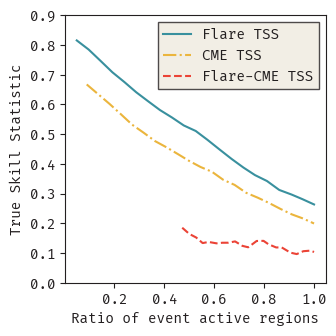

In [50]:
# Plot this now

fig, ax = plt.subplots(1, 1, figsize=(onecolumn, onecolumn))

ax.plot(flare_ratio_values, flare_tss_values, label="Flare TSS", color=colors["blue"])
ax.plot(cme_ratio_values, cme_tss_values, label="CME TSS", color=colors["yellow"], linestyle="-.")
ax.plot(cme_flare_ratio_values, cme_flare_tss_values, label="Flare-CME TSS", color=colors["red"], linestyle="--")

ax.legend(fontsize=10, fancybox=False, facecolor=colors["beige"], edgecolor=colors["black"])

ax.set_ylim(0.0, 0.9)

ax.set_xlabel("Ratio of event active regions")
ax.set_ylabel("True Skill Statistic")
plt.tight_layout()

plt.savefig("active_regions_tss.pdf", bbox_inches="tight")

# Distribution of predictions

In [4]:
preds_path = "../out/main_predictions.db"

conn = sqlite3.connect(preds_path)
cur = conn.cursor()

for table in ["flare_forecast", "cme_forecast", "flare_cme_assoc"]:
    cur.execute(f"CREATE INDEX IF NOT EXISTS {table}_harpnum_idx ON {table}_rotary_transformer_24_predictions (harpnum)")
    cur.execute(f"CREATE INDEX IF NOT EXISTS {table}_run_id_idx ON {table}_rotary_transformer_24_predictions (run_id)")

# Attach ../data/features.db

cur.execute("ATTACH DATABASE '../data/features.db' AS features")

# Delete temp view if exists
cur.execute("DROP TABLE IF EXISTS combined_forecasts")

cur.executescript("""
CREATE INDEX IF NOT EXISTS idx_flare_forecast ON flare_forecast_rotary_transformer_24_predictions(run_id, harpnum, start);
CREATE INDEX IF NOT EXISTS idx_cme_forecast ON cme_forecast_rotary_transformer_24_predictions(run_id, harpnum, start);
CREATE INDEX IF NOT EXISTS idx_flare_cme_assoc ON flare_cme_assoc_rotary_transformer_24_predictions(run_id, harpnum, start);

CREATE TEMP TABLE IF NOT EXISTS combined_forecasts AS
WITH unique_keys AS (
    SELECT run_id, harpnum, start, end FROM flare_forecast_rotary_transformer_24_predictions
    UNION
    SELECT run_id, harpnum, start, end FROM cme_forecast_rotary_transformer_24_predictions
    UNION
    SELECT run_id, harpnum, start, end FROM flare_cme_assoc_rotary_transformer_24_predictions
),
baselines AS (
                  SELECT 
                  harpnum, 
                  MAX(has_flare_above_threshold) AS baseline_flare,
                  MAX(MAX(has_cme_flare_above_threshold), MAX(has_cme_flare_below_threshold)) AS baseline_cme,
                  MAX(has_cme_flare_above_threshold) AS baseline_cme_flare
                  FROM features.T_24_L_24_S_0_2_B_0_OVERLAPS_1_MIN_FLARE_30_dataset
                  GROUP BY harpnum
),
combined_data AS (
    SELECT 
        uk.run_id, 
        uk.harpnum, 
        uk.start,
        uk.end,
        f.pred AS flare_pred, f.target AS flare_target,
        c.pred AS cme_pred, c.target AS cme_target,
        fc.pred AS flare_cme_pred, fc.target AS flare_cme_target,
        s.baseline_cme as base_cme_pred,
        s.baseline_cme_flare as base_flare_cme_pred,
        s.baseline_flare as base_flare_pred
    FROM unique_keys uk
    LEFT JOIN flare_forecast_rotary_transformer_24_predictions f ON uk.run_id = f.run_id AND uk.harpnum = f.harpnum AND uk.start = f.start
    LEFT JOIN cme_forecast_rotary_transformer_24_predictions c ON uk.run_id = c.run_id AND uk.harpnum = c.harpnum AND uk.start = c.start
    LEFT JOIN flare_cme_assoc_rotary_transformer_24_predictions fc ON uk.run_id = fc.run_id AND uk.harpnum = fc.harpnum AND uk.start = fc.start
    INNER JOIN baselines s ON uk.harpnum = s.harpnum
)
SELECT * FROM combined_data;
""")

In [5]:
data = pd.read_sql("""
SELECT * FROM combined_forecasts
                    """, conn)

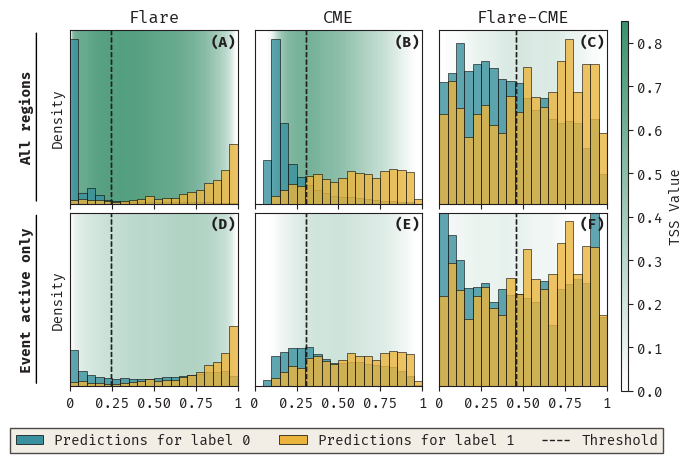

-0.021087736339714766 0.8173643847669605


In [53]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
import matplotlib.patches as patches

bins = np.arange(0, 1.01, 0.05)

flare_data = data[~data["flare_target"].isna()].copy()
cme_data = data[~data["cme_target"].isna()].copy()
flare_cme_data = data[~data["flare_cme_target"].isna()].copy()

flare_active_data = flare_data[flare_data["base_flare_pred"] == 1]
cme_active_data = cme_data[cme_data["base_cme_pred"] == 1]
flare_cme_active_data = flare_cme_data[flare_cme_data["base_flare_cme_pred"] == 1]


fig, axes = plt.subplots(2, 3, figsize=(twocolumn, 2 * twocolumn/3), sharex=True, sharey=False, gridspec_kw={"hspace": 0.05, "wspace": 0.1})

# Calculate global TSS range for consistent color mapping across plots
all_tss_values = []

# Define colormap normalization
norm = Normalize(vmin=0, vmax=0.85)
cmap = LinearSegmentedColormap.from_list("custom", ["white", colors["green"]])

# Make a custom colormap going from white to colors["orange"]
ylims = {}

letters = ["A", "B", "C", "D", "E", "F"]
m = 0

for j, all_data in enumerate([[flare_data, cme_data, flare_cme_data], [flare_active_data, cme_active_data, flare_cme_active_data]]):
    for i, (forecast_data, title) in enumerate(zip(all_data, ["Flare", "CME", "Flare-CME"])):
        ax = axes[j,i]
        ax.set_aspect('equal')
        column = f"{title.replace('-', '_').lower()}"

        # Put the letter on top right of plot
        # Anchor top right of text
        ax.text(0.99,0.98, f"({letters[m]})", transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='bold')
        m += 1

        # Plot histograms
        for target in [0, 1]:
            target_data = forecast_data[forecast_data[f"{column}_target"] == target]
            ax.hist(target_data[f"{column}_pred"], bins=bins, alpha=0.8, color=colors["yellow"] if target == 1 else colors["blue"], edgecolor="black", linewidth=0.5, density=True)
            # Plot the threshold
            ax.axvline(thresholds[column], color=colors["black"], linestyle="--", linewidth=1)

            if j == 0:
                ylims[column] = ax.get_ylim()
            else:
                ax.set_ylim(ylims[column])
            
            original_y_max = ax.get_ylim()[1]
        
        # Plot background TSS value coloring
        tss_values = vectorized_true_skill_statistic(forecast_data[f"{column}_target"], forecast_data[f"{column}_pred"], tss_thresholds)
        all_tss_values.extend(tss_values)
        # Create a continuous background color image based on TSS values
        ax.imshow(np.tile(tss_values, (100, 1)), aspect='auto', extent=[0, 1, 0, original_y_max], origin='lower', cmap=cmap, alpha=0.9, zorder=-1, norm=norm)
        
        if j == 0:
            ax.set_title(title)
        #ax.set_xlabel("Prediction")
        ax.set_xlim(0, 1)

        # Remove every tick and label from y axis
        ax.set_yticks([])

axes[0,0].set_ylabel("Density")
axes[1,0].set_ylabel("Density")

for ax in axes[1,:]:
    # Set xticks to 0, 0.25, 0.5, 0.75, 1
    # But for 0 and 1 no decimals
    ax.set_xticks(np.arange(0, 1.01, 0.25))
    ax.set_xticklabels([f"{x:.0f}" if x in [0, 1] else f"{x:.2f}" for x in np.arange(0, 1.01, 0.25)]) 

# plt.tight_layout()

# Adjustments for adding the vertical lines and text
for j, label in enumerate(["All regions", "Event active only"]):
    ax = axes[j, 0]  # Reference to the first plot in each row
    # Use Line2D to draw a vertical line
    # Drawing a line with annotate
    ax.annotate('', xy=(-0.2, 0), xytext=(-0.2 , 1), xycoords='axes fraction', 
                textcoords='axes fraction', arrowprops=dict(arrowstyle="-", color="black"))
    
    # Add vertical text aligned with the line. Adjust x and y values for positioning.
    ax.text(-0.3, 0.5, label, rotation=90, transform=ax.transAxes, verticalalignment='center', horizontalalignment='left', fontweight='bold')

# Adjust layout to accommodate the new text elements
# plt.tight_layout(rect=[0.05, 0, 0.95, 1])

# Create a colorbar with the same normalization and colormap
fig.subplots_adjust(right=0.90)
cbar_ax = fig.add_axes([0.92, 0.1, 0.01, 0.8])  # Adjust the position and size as needed
sm = ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(sm, cax=cbar_ax, label='TSS Value')

# Now need a manual legend
# A blue bar for "Predictions for label 0" and a yellow bar for "Predictions for label 1
# Then a dashed line for the threshold

# Create custom legend handles using rectangles for bars
legend_elements = [
    patches.Patch(facecolor=colors["blue"], edgecolor='black', linewidth=0.5, label='Predictions for label 0'),
    patches.Patch(facecolor=colors["yellow"], edgecolor='black', linewidth=0.5, label='Predictions for label 1'),
    Line2D([0], [0], color=colors["black"], lw=1, linestyle='--', label='Threshold')
]

# Place the legend on the figure
fig.legend(handles=legend_elements, ncol=3, bbox_to_anchor=(0.51, -0.05), loc='lower center', fancybox=False, facecolor=colors["beige"], edgecolor=colors["black"])
plt.savefig("predictions_distributions.pdf", bbox_inches="tight")

plt.show()


print(min(all_tss_values), max(all_tss_values))


# Plot example region predictions

In [66]:
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

def plot_region_cmes(harpnums, sidetitles, events, sharex=False, highlight_span_of=None, mode="row"):
    if len(harpnums) != len(sidetitles):
        raise ValueError("harpnums and sidetitles must have the same length")

    n = len(harpnums)
    
    if mode == "row":
        fig, axes = plt.subplots(1, n, figsize=(twocolumn, twocolumn/3), sharey=True, sharex=sharex, gridspec_kw={"wspace": 0.2})
    elif mode =="column":
        fig, axes = plt.subplots(n, 1, figsize=(onecolumn, n * onecolumn), sharex=True, sharey=False, gridspec_kw={"hspace": 0.2})
    else:
        raise ValueError("mode must be either 'row' or 'column'")

    for i, harpnum in enumerate(harpnums):
        ax = axes[i]
        hdata = data[data["harpnum"] == harpnum].copy()

        hruns = hdata["run_id"].unique()

        hdata = hdata[hdata["run_id"] == hruns[0]]

        hdata["end"] = pd.to_datetime(hdata["end"])

        dates, predictions, labels = hdata[["end", f"{events[i]}_pred", f"{events[i]}_target"]].dropna().values.T

        if highlight_span_of == i:
            span_start, span_end = dates.min(), dates.max()

        ax.plot(dates, labels, color=colors["blue"], linewidth=2, solid_capstyle='round')
        ax.plot(dates, predictions, color=colors["yellow"], linewidth=2, solid_capstyle='round')

        ax.set_title(f"{sidetitles[i]}", fontsize=10, rotation=-90,ha='left', va='top', y=0.96, x=1.01)

        # Set secondary title
        ax.text(0, 1.01, f"HARPNUM: {harpnum}", transform=ax.transAxes, horizontalalignment='left', verticalalignment='bottom', fontsize=10, fontweight='bold')

        # Plot threshold
        ax.axhline(thresholds[f"{events[i]}"], color=colors["black"], linestyle="--", linewidth=2, zorder=-1)


    # Format to one day

    for ax in axes:
        ax.set_ylim(-0.05,1.05)


        if highlight_span_of:
            ax.axvspan(span_start, span_end, color=colors["black"], alpha=0.1, zorder=-1)

        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))

        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

        ax.set_xticklabels([])


    # Set y ticks to 0, threshold, 1
    # Format to 2 decimal places
    if mode == "row":
        ticks = [0] + [thresholds[event] for event in set(events)] + [1]
        axes[0].set_yticks(ticks)
        axes[0].set_yticklabels([f"{x:.2f}" if x not in [0,1] else f"{x}" for x in ticks])
    else:
        for i in range(n):
            ticks = [0, thresholds[events[i]], 1]
            axes[i].set_yticks(ticks)
            axes[i].set_yticklabels([f"{x:.2f}" if x not in [0,1] else f"{x}" for x in ticks])


    # Now need a manual legend
    legend_elements = [
        Line2D([0], [0], color=colors["blue"], lw=2, label='Target'),
        Line2D([0], [0], color=colors["yellow"], lw=2, label='Prediction'),
        Line2D([0], [0], color=colors["black"], lw=2, linestyle='--', label='Threshold')
    ]

    if mode == "row":
        ncol = 3
        pos = (0.5, -0.1)
    else:
        ncol = 1
        pos = (0.5, -0.05)
    # Place the legend on the figure
    fig.legend(handles=legend_elements, ncol=ncol, bbox_to_anchor=pos, loc='lower center', fancybox=False, facecolor=colors["beige"], edgecolor=colors["black"])


    return fig

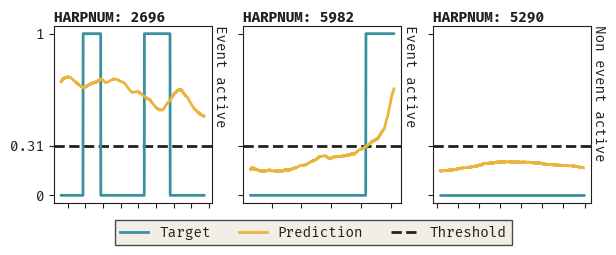

In [67]:
fig = plot_region_cmes([2696, 5982, 5290], ["Event active", "Event active", "Non event active"], ["cme", "cme", "cme"])

plt.savefig("cme_predictions_example.pdf", bbox_inches="tight")

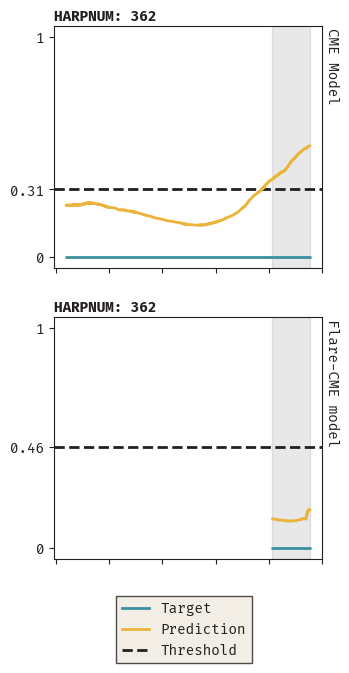

In [68]:
fig = plot_region_cmes([362, 362], ["CME Model", "Flare-CME model"], ["cme", "flare_cme"], sharex=True, highlight_span_of=1, mode="column")

# Class imbalance vs event active ratio

left
Class imbalance: 14.0
Event active ratio: 0.2222222222222222
right
Class imbalance: 14.0
Event active ratio: 0.6666666666666666


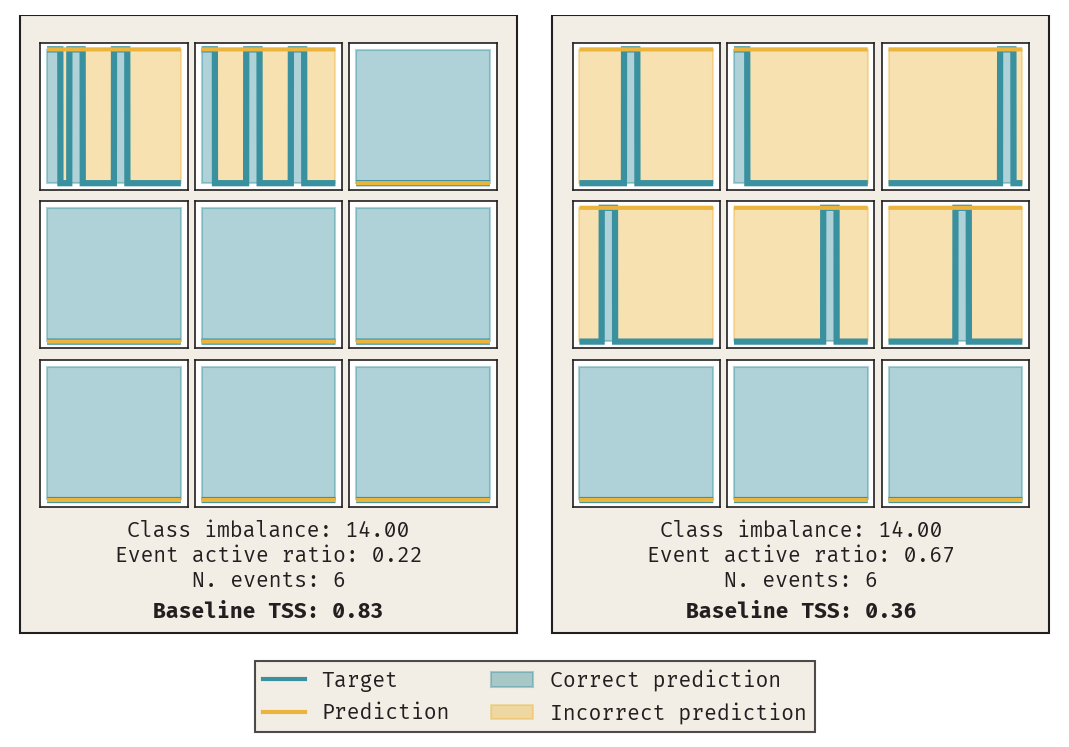

In [37]:
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
np.random.seed(410112)
# Import Line2D
from matplotlib.lines import Line2D

def mix_colors(color1, color2, alpha=0.5):
    """
    Mix two colors together.
    
    Parameters:
    - color1: The first color. Any format recognized by matplotlib (e.g., name, hex, RGB).
    - color2: The second color. Any format recognized by matplotlib.
    - alpha: The weight of the first color. 1.0 will be all color1, 0.0 will be all color2.
    
    Returns: The mixed color.
    """
    # Convert colors to RGBA format
    c1 = mcolors.to_rgba(color1)
    c2 = mcolors.to_rgba(color2)
    
    # Mix the colors
    mix = [alpha * c1[i] + (1 - alpha) * c2[i] for i in range(4)]
    return mix

N_events = 6
N_event_active_left = 2
N_event_active_rigth = 6
N_event_active = {
    "left": N_event_active_left,
    "right": N_event_active_rigth
}
N_points_per_region = int(10 * 24 / 0.2)
N_points_per_event = int(24 / 0.2)

fig = plt.figure(figsize=(twocolumn, twocolumn / 2), dpi=150)
subfig1, subfig2 = fig.subfigures(1, 2, wspace=0.05)

fixed_sep = 0.05  # Fixed separation value, for example, 2% of figure size
pad = 0.05
subfig1.subplots_adjust(left=pad, right=1-pad, top=1-pad, bottom=pad, wspace=fixed_sep, hspace=fixed_sep)
subfig2.subplots_adjust(left=pad, right=1-pad, top=1-pad, bottom=pad, wspace=fixed_sep, hspace=fixed_sep)

# Choose your background color
bg_color1 = mix_colors(colors["beige"], "white", 0.8)
bg_color2 = mix_colors(colors["beige"], "white", 0.8)

# Create a "background" axes that spans the entire figure
background_ax1 = subfig1.add_axes([0, -0.20, 1, 1.20], zorder=-1)
background_ax2 = subfig2.add_axes([0, -0.20, 1, 1.20], zorder=-1)

# Remove all ticks, axes and everything from the background
background_ax1.axis('off')
background_ax2.axis('off')

# Create background rectangles and add them to the subfigures
# The Rectangle coordinates are set to the subfigure's extents with lower left corner at (0, 0)
background_ax1.add_patch(Rectangle((0.01, -0.19), 0.98, 1.19, transform=subfig1.transSubfigure, facecolor=bg_color1, zorder=-1, edgecolor=colors["black"]))
background_ax2.add_patch(Rectangle((0.01, -0.19), 0.98, 1.19, transform=subfig2.transSubfigure, facecolor=bg_color2, zorder=-1, edgecolor=colors["black"]))

axes1 = subfig1.subplots(3, 3, sharex=True, sharey=True)
axes2 = subfig2.subplots(3, 3, sharex=True, sharey=True)

# Make every subplot have equal aspect ratio
# And remove all ticks

for ax in axes1.flat:
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

for ax in axes2.flat:
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

norm_x = np.linspace(0, 1, N_points_per_region)

axes = {
    "left": axes1,
    "right": axes2
}

backgrounds = {
    "left": background_ax1,
    "right": background_ax2
}

# Now we need to generate the data

labels = {
    "left": [],
    "right": []
}
preds = {
    "left": [],
    "right": []
}

event_starts = {
    "left": [],
    "right": []
}

class_imbalance = {
    "left": None,
    "right": None
}

event_active_ratio = {
    "left": N_event_active_left / 9,
    "right": N_event_active_rigth / 9
}

all_labels = {
    "left": None,
    "right": None
}

all_preds = {
    "left": None,
    "right": None
}

TSS_values = {
    "left": None,
    "right": None
}

for side in ["left", "right"]:
    for i in range(9):
        N_events_per_active = N_events // N_event_active[side]
        if i < N_event_active[side]:
            # Need N_events_per_active numbers from 0 to N_points_per_region - N_points_per_events separated by at least N_points_per_events + 1
            cevent_starts = np.sort(np.random.choice(np.arange(0, N_points_per_region - N_points_per_event, N_points_per_event + 80), size=N_events_per_active, replace=False))

            clabels = np.zeros(N_points_per_region)

            for start in cevent_starts:
                clabels[start:start + N_points_per_event] = 1

            labels[side].append(clabels)
            preds[side].append(list(np.ones_like(clabels)))
            event_starts[side].append(cevent_starts)

        else:
            labels[side].append(list(np.zeros(N_points_per_region)))
            preds[side].append(list(np.zeros(N_points_per_region)))
            event_starts[side].append([])
        
    all_labels[side] = np.array(labels[side]).flatten()
    all_preds[side] = np.array(preds[side]).flatten()

    cm = confusion_matrix(all_labels[side], all_preds[side])

    #Unravel
    TN, FP, FN, TP = cm.ravel()

    TSS = TP / (TP + FN) - (FP / (FP + TN))

    TSS_values[side] = TSS

    class_imbalance[side] = np.sum(all_labels[side] == 0) / np.sum(all_labels[side] == 1)

# Plot the data
    current_event_starts = event_starts[side]

    print(side)
    print("Class imbalance:", class_imbalance[side])
    print("Event active ratio:", event_active_ratio[side])

    vline_alpha = 0.4
    correct_color = colors["blue"]
    incorrect_color = colors["yellow"]
    for i, ax in enumerate(axes[side].flat):
        ax.plot(norm_x, labels[side][i], color=colors["blue"], linewidth=3, solid_capstyle='butt', solid_joinstyle="miter")
        ax.plot(norm_x, np.array(preds[side][i]), color=colors["yellow"], linewidth=2, solid_capstyle='butt')

        # Now we need to plot several axvspans, where the region is event active and is within event green, outside red
        # For non event active, all green


        if len(current_event_starts[i]) > 0:
            for j in range(len(current_event_starts[i])):
                event_start = current_event_starts[i][j]

                if j == 0 and event_start != 0:
                    ax.axvspan(0, event_start / N_points_per_region, color=incorrect_color, alpha=vline_alpha, ymin=0.05, ymax=0.95)
                
                if j == len(current_event_starts[i]) - 1 and event_start != N_points_per_region - N_points_per_event:
                    ax.axvspan((event_start + N_points_per_event) / N_points_per_region, 1, color=incorrect_color, alpha=vline_alpha, ymin=0.05, ymax=0.95)
                
                ax.axvspan(event_start / N_points_per_region, (event_start + N_points_per_event) / N_points_per_region, color=correct_color, alpha=vline_alpha, ymin=0.05, ymax=0.95)

                # Now, check if it's not the last event, need to fill between end of this and start of next with red

                if j != len(current_event_starts[i]) - 1:
                    next_start = current_event_starts[i][j + 1]

                    ax.axvspan((event_start + N_points_per_event) / N_points_per_region, next_start / N_points_per_region, color=incorrect_color, alpha=vline_alpha, ymin=0.05, ymax=0.95)
        else:
            # All green
            ax.axvspan(0, 1, color=correct_color, alpha=vline_alpha, ymin=0.05, ymax=0.95)

    # Put now text on the bottom of the plots
    background_ax = backgrounds[side]

    background_ax.text(0.5, 0.19, f"Class imbalance: {class_imbalance[side]:.2f}\nEvent active ratio: {event_active_ratio[side]:.2f}\nN. events: {N_events}", transform=background_ax.transAxes, horizontalalignment='center', fontsize=10, va="top")
    background_ax.text(0.5, 0.06, f"Baseline TSS: {TSS_values[side]:.2f}", transform=background_ax.transAxes, horizontalalignment='center', fontsize=10, va="top", weight="bold")

# Now a legend

legend_elements = [
    Line2D([0], [0], color=colors["blue"], lw=2, label='Target'),
    Line2D([0], [0], color=colors["yellow"], lw=2, label='Prediction'),
    Rectangle((0, 0), 1, 1, color=correct_color, alpha=vline_alpha, label='Correct prediction'),
    Rectangle((0, 0), 1, 1, color=incorrect_color, alpha=vline_alpha, label='Incorrect prediction')
]

# Place the legend on the figure

fig.legend(handles=legend_elements, ncol=2, bbox_to_anchor=(0.5, -0.40), loc='lower center', fancybox=False, facecolor=colors["beige"], edgecolor=colors["black"])

plt.savefig("event_active_regions.pdf", bbox_inches="tight")

# Testing ground for the ratio of events stuff

In [160]:
from sklearn.metrics import confusion_matrix
import torch
# Suppose we have 2000 regions
n_regions = 500

# Let's assume we have 17 days of data, at a cadence of 1 hour for all of them
n_points_per_region = int(17 * 24)

# Now, we'll make a grid and we must evaluate the TSS in it using baseline models.

ratios = np.linspace(10 / n_regions, (n_regions - 10) / n_regions, 20)
active_ratios_per_region = np.linspace(10 / n_points_per_region, (n_points_per_region - 10) / n_points_per_region, 20)

actual_ratios = np.zeros_like(ratios)
actual_active_ratios_per_region = np.zeros_like(active_ratios_per_region)

tss_values = np.zeros((len(ratios), len(active_ratios_per_region)))

for i, ratio in tqdm(enumerate(ratios)):
    for j, active_ratio_per_region in enumerate(active_ratios_per_region):
        n_active = int(n_regions * ratio)
        n_non_active = n_regions - n_active
        n_active_points_per_region = int(n_points_per_region * active_ratio_per_region)


#        if ratio == 0.0:
#            # NO event active regions, all labels and preds 0 so TSS = 1
#            # NO event active, so all predictions correct and TSS = 1
#            tss_values[i, j] = 1
#            continue
#
#        if ratio == 1.0:
#            # We have two cases
#            if active_ratio_per_region == 0:
#                # No actual activity but predicting always 1 so all wrong. TSS = 0
#                tss_values[i, j] = 0
#                continue
#            if active_ratio_per_region == 1:
#                # All labels and preds = 1, so TSS = 1
#                tss_values[i, j] = 1
#                continue

        actual_ratio = n_active / (n_active + n_non_active)
        actual_ratios[i] = actual_ratio

        active_regions_labels = ((np.random.rand(n_active, n_points_per_region) + 0.5 * np.random.rand(n_active, 1).repeat(n_points_per_region, axis=-1))< active_ratio_per_region).astype(int)
        active_predictions = np.ones_like(active_regions_labels)

        non_active_labels = np.zeros((n_non_active, n_points_per_region))

        non_active_preds = np.zeros_like(non_active_labels)

        all_labels = np.concatenate([active_regions_labels, non_active_labels], axis=0).flatten()
        all_preds = np.concatenate([active_predictions, non_active_preds], axis=0).flatten()

        cm = confusion_matrix(all_labels, all_preds)

        TN, FP, FN, TP = cm.ravel()

        recall = TP / (TP + FN)

        TSS = recall - (FP / (FP + TN))

        tss_values[i, j] = TSS

0it [00:00, ?it/s]/tmp/ipykernel_7938/4134044714.py:60: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP / (TP + FN)
20it [00:26,  1.34s/it]


In [161]:
tss_values[0]

array([0.98010089,        nan, 0.98022103, 0.98087991, 0.98123135,
       0.98094247, 0.98261066, 0.98228236, 0.98252857, 0.98410526,
       0.98492948, 0.98765432, 0.98717151, 0.98780072, 0.98885608,
       0.99020788, 0.99126839, 0.99112096, 0.99321364, 0.9943894 ])

[Text(0, 0, '0.02'),
 Text(0, 1, '0.07'),
 Text(0, 2, '0.12'),
 Text(0, 3, '0.17'),
 Text(0, 4, '0.22'),
 Text(0, 5, '0.27'),
 Text(0, 6, '0.32'),
 Text(0, 7, '0.37'),
 Text(0, 8, '0.42'),
 Text(0, 9, '0.47'),
 Text(0, 10, '0.53'),
 Text(0, 11, '0.58'),
 Text(0, 12, '0.63'),
 Text(0, 13, '0.68'),
 Text(0, 14, '0.73'),
 Text(0, 15, '0.78'),
 Text(0, 16, '0.83'),
 Text(0, 17, '0.88'),
 Text(0, 18, '0.93'),
 Text(0, 19, '0.98')]

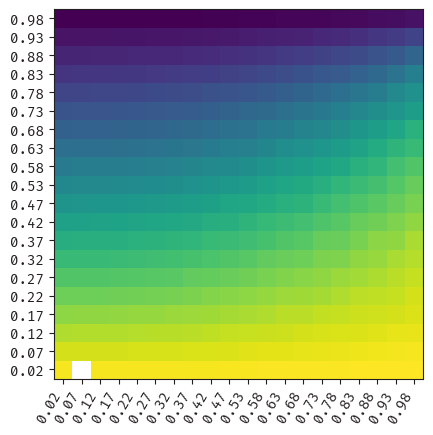

In [162]:
fig, ax = plt.subplots()

ax.imshow(tss_values, origin="lower")
ax.set_xticks([i for i in range(len(active_ratios_per_region))])
ax.set_yticks([i for i in range(len(ratios))])
ax.set_xticklabels([f"{i:.2f}" for i in active_ratios_per_region], rotation=60, ha="right", va="top")
ax.set_yticklabels([f"{i:.2f}" for i in ratios])

In [83]:
a = np.random.rand(10, 2)
b = np.random.rand(20, 2)

np.concatenate([a,b], axis=0).flatten().shape

(60,)

In [152]:
a = np.random.rand(10,1).repeat(2, axis=-1)
a.shape

(10, 2)

In [153]:
a

array([[0.36652302, 0.36652302],
       [0.09322524, 0.09322524],
       [0.74933919, 0.74933919],
       [0.46033531, 0.46033531],
       [0.25569522, 0.25569522],
       [0.40395937, 0.40395937],
       [0.91369536, 0.91369536],
       [0.09601989, 0.09601989],
       [0.99344147, 0.99344147],
       [0.07527386, 0.07527386]])